

> TFG (No es la version final)




1.   Importación de datos
2.   Preprocesamiento de los datos
3.   Modelo de clasificacion (transfer learning y modelo simple)
4.   Modelo de segmentacion con los resultados del modelo anterior
5.   Representacion de los resultados




# Librerias

In [6]:
import zipfile
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# 1. Importación de los datos


In [7]:
def extract_zip(zip_path, dest_dir):
    """
    Extrae el contenido de un archivo zip a un directorio de destino.

    Args:
        zip_path (str): La ruta al archivo zip.
        dest_dir (str): El directorio donde se extraerán los archivos.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

# Define las rutas del archivo zip y el directorio de destino
zip_file_path = '/content/archive.zip'
destination_directory = '/content'

# Llama a la función para extraer el archivo
if os.path.exists(zip_file_path):
    extract_zip(zip_file_path, destination_directory)
    print(f"Archivo '{zip_file_path}' extraído a '{destination_directory}'")
else:
    print(f"El archivo '{zip_file_path}' no fue encontrado.")

Archivo '/content/archive.zip' extraído a '/content'


In [8]:
def importar(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(img_path)
                image_list.append(img)
            except Exception as e:
                print(f"No se pudo abrir la imagen {filename}: {e}")
    return image_list

In [9]:
imagenes_ct_sanas = importar('/content/Dataset/Brain Tumor CT scan Images/Healthy')
imagenes_ct_tumor = importar('/content/Dataset/Brain Tumor CT scan Images/Tumor')
imagenes_mri_sanas = importar('/content/Dataset/Brain Tumor MRI images/Healthy')
imagenes_mri_tumor = importar('/content/Dataset/Brain Tumor MRI images/Tumor')

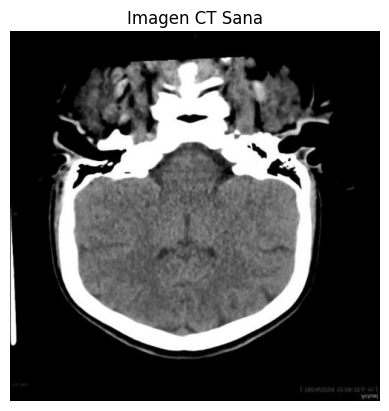

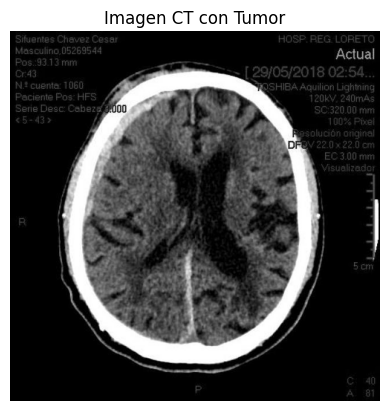

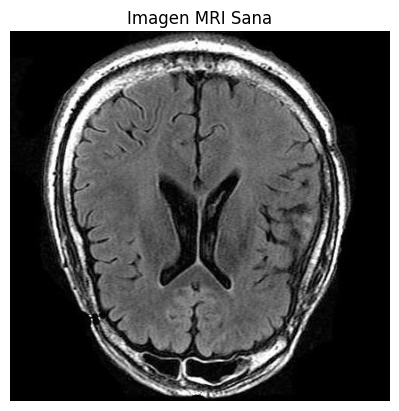

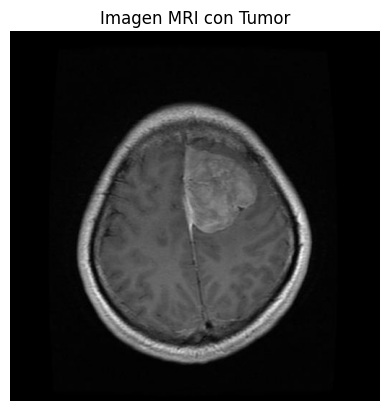

In [10]:
def display_image(image_list, title):
    if image_list:
        random_index = np.random.randint(0, len(image_list))
        plt.imshow(image_list[random_index], cmap='grey')
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        print(f"La lista '{title}' está vacía.")

display_image(imagenes_ct_sanas, "Imagen CT Sana")
display_image(imagenes_ct_tumor, "Imagen CT con Tumor")
display_image(imagenes_mri_sanas, "Imagen MRI Sana")
display_image(imagenes_mri_tumor, "Imagen MRI con Tumor")

# 2. Preprocesamiento de los datos

In [11]:
def preprocess_images(image_list, target_size=(256, 256)):
    processed_images = []
    for img in image_list:
        # Convierto a array NumPy y asegurar que sea RGB
        img_array = np.array(img.convert('RGB')) if img.mode != 'RGB' else np.array(img)
        # Redimensiono todas las imágenes al mismo tamaño objetivo
        resized_img = cv2.resize(img_array, target_size)
        # Normalizo (escalar los valores de píxel a un rango de 0 a 1)
        normalized_img = resized_img.astype('float32') / 255.0
        processed_images.append(normalized_img)
    return processed_images

imagenes_ct_sanas_processed = preprocess_images(imagenes_ct_sanas)
imagenes_ct_tumor_processed = preprocess_images(imagenes_ct_tumor)
imagenes_mri_sanas_processed = preprocess_images(imagenes_mri_sanas)
imagenes_mri_tumor_processed = preprocess_images(imagenes_mri_tumor)

print(f"Se preprocesaron {len(imagenes_ct_sanas_processed)} imágenes CT sanas.")
print(f"Se preprocesaron {len(imagenes_ct_tumor_processed)} imágenes CT con tumor.")
print(f"Se preprocesaron {len(imagenes_mri_sanas_processed)} imágenes MRI sanas.")
print(f"Se preprocesaron {len(imagenes_mri_tumor_processed)} imágenes MRI con tumor.")

Se preprocesaron 2300 imágenes CT sanas.
Se preprocesaron 2318 imágenes CT con tumor.
Se preprocesaron 2000 imágenes MRI sanas.
Se preprocesaron 3000 imágenes MRI con tumor.


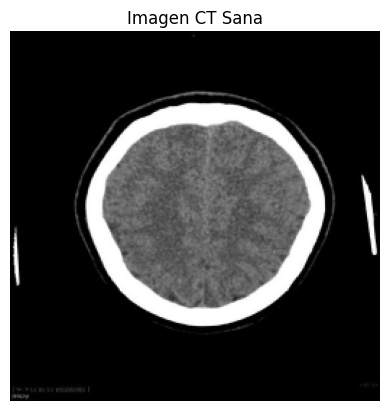

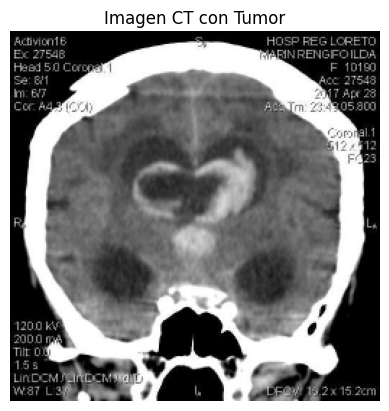

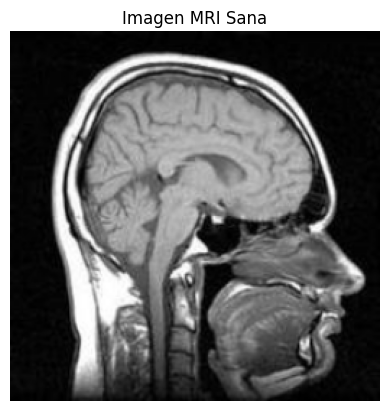

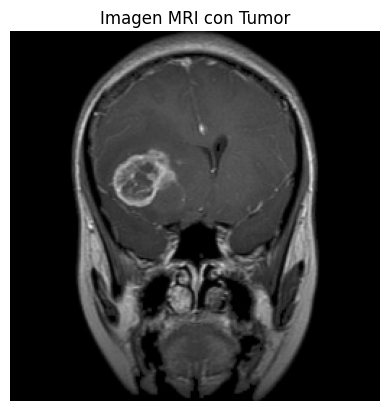

In [12]:
display_image(imagenes_ct_sanas_processed, "Imagen CT Sana")
display_image(imagenes_ct_tumor_processed, "Imagen CT con Tumor")
display_image(imagenes_mri_sanas_processed, "Imagen MRI Sana")
display_image(imagenes_mri_tumor_processed, "Imagen MRI con Tumor")

# 3. Modelo de clasificación conjunto ct

Primer modelo, voy a ir cambiando el modelo hasta llegar a un modelo con un rendimiento mejorado respecto al resto.

## Primer modelo

In [ ]:
imagenes_ct = imagenes_ct_sanas_processed + imagenes_ct_tumor_processed
# 0 para sanas, 1 para tumor
labels_ct = [0] * len(imagenes_ct_sanas_processed) + [1] * len(imagenes_ct_tumor_processed)
imagenes_ct = np.array(imagenes_ct)
labels_ct = np.array(labels_ct)
X_train_ct, X_test_ct, y_train_ct, y_test_ct = train_test_split(
    imagenes_ct, labels_ct,
    test_size=0.2, random_state=42, stratify=labels_ct)
print(f"Tamaño del conjunto de entrenamiento: {len(X_train_ct)}")
print(f"Tamaño del conjunto de prueba: {len(X_test_ct)}")

Tamaño del conjunto de entrenamiento: 3694
Tamaño del conjunto de prueba: 924


In [ ]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       492,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493,441 (1.88 MB)

 Trainable params: 493,441 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entreno el modelo
history = model.fit(X_train_ct, y_train_ct, epochs=20, batch_size=64, validation_split=0.2)

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9584 - loss: 0.1875
Pérdida en el conjunto de prueba: 0.2239
Precisión en el conjunto de prueba: 0.9556


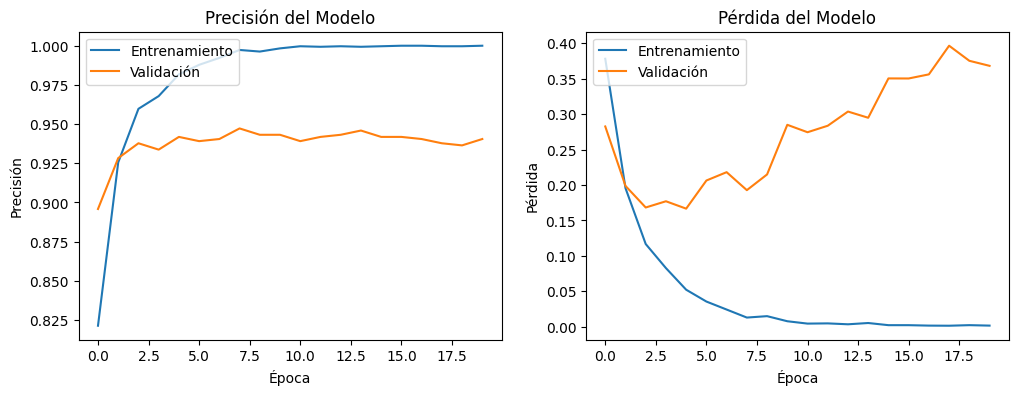

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

## Segundo modelo

In [ ]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.75),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.75),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │       492,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493,441 (1.88 MB)

 Trainable params: 493,441 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entreno el modelo
history = model.fit(X_train_ct, y_train_ct, epochs=100, batch_size=64, validation_split=0.2)

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9689 - loss: 0.1048
Pérdida en el conjunto de prueba: 0.1317
Precisión en el conjunto de prueba: 0.9665


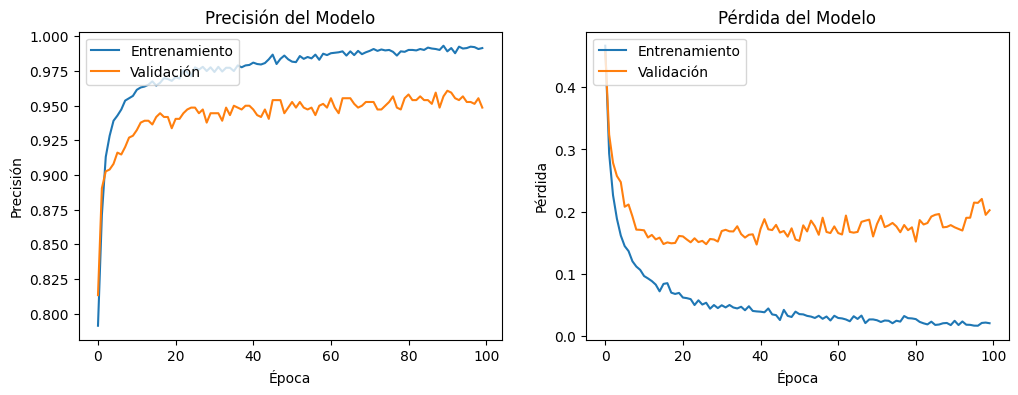

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

## Tercer modelo

In [ ]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.65),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.65),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.65),
    # Conv2D(16, (3, 3), activation='relu'),
    # MaxPooling2D((2, 2)),
    # Dropout(0.65),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │       230,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,753 (956.07 KB)

 Trainable params: 244,753 (956.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entreno el modelo
history = model.fit(X_train_ct, y_train_ct, epochs=200, batch_size=64, validation_split=0.2)

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_ct, y_test_ct)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9677 - loss: 0.1143
Pérdida en el conjunto de prueba: 0.1232
Precisión en el conjunto de prueba: 0.9632


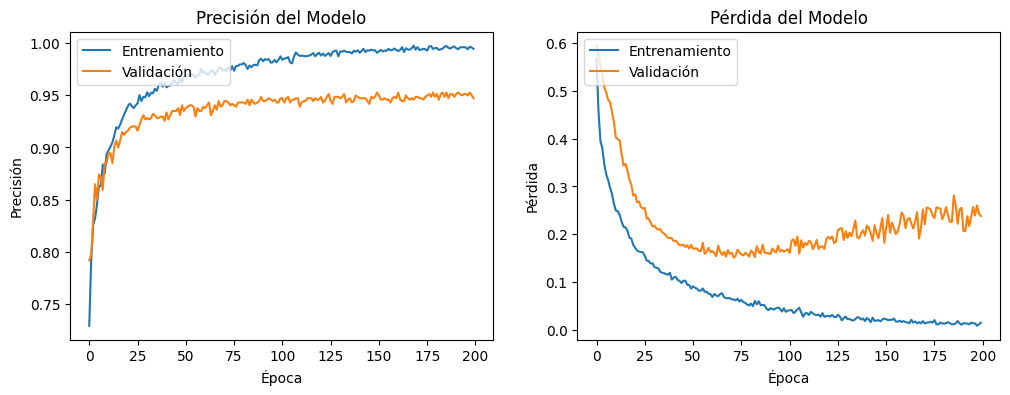

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

# 4. Modelo de clasificación conjunto mri

Primer modelo, voy a ir cambiando el modelo hasta llegar a un modelo con un rendimiento mejorado respecto al resto.

## Primer modelo

In [13]:
imagenes_mri = imagenes_mri_sanas_processed + imagenes_mri_tumor_processed
# 0 para sanas, 1 para tumor
labels_mri = [0] * len(imagenes_mri_sanas_processed) + [1] * len(imagenes_mri_tumor_processed)
imagenes_mri = np.array(imagenes_mri)
labels_mri = np.array(labels_mri)
X_train_mri, X_test_mri, y_train_mri, y_test_mri = train_test_split(
    imagenes_mri, labels_mri,
    test_size=0.2, random_state=42, stratify=labels_mri)
print(f"Tamaño del conjunto de entrenamiento: {len(X_train_mri)}")
print(f"Tamaño del conjunto de prueba: {len(X_test_mri)}")

Tamaño del conjunto de entrenamiento: 4000
Tamaño del conjunto de prueba: 1000


In [ ]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │       492,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493,441 (1.88 MB)

 Trainable params: 493,441 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entreno el modelo
history = model.fit(X_train_mri, y_train_mri, epochs=20, batch_size=64, validation_split=0.2)

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9495 - loss: 0.2266
Pérdida en el conjunto de prueba: 0.2653
Precisión en el conjunto de prueba: 0.9380


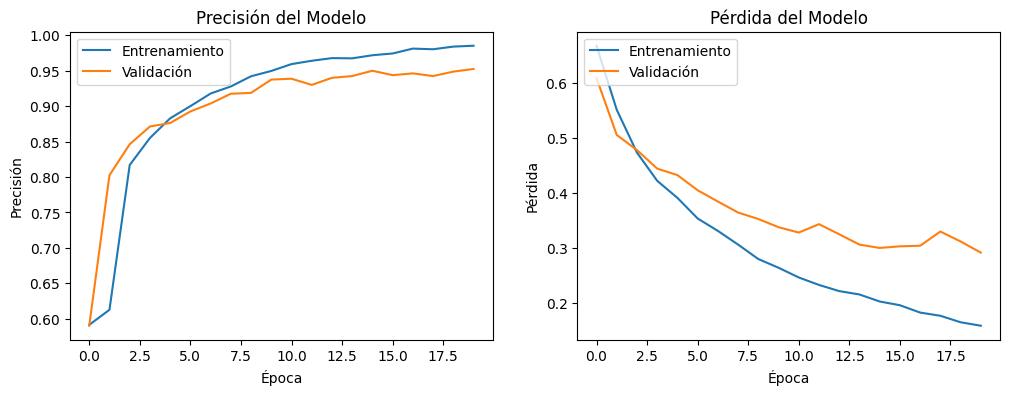

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

## Segundo modelo

In [ ]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │       492,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493,441 (1.88 MB)

 Trainable params: 493,441 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entreno el modelo
history = model.fit(X_train_mri, y_train_mri, epochs=60, batch_size=64, validation_split=0.2)

In [ ]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9467 - loss: 0.2677
Pérdida en el conjunto de prueba: 0.2614
Precisión en el conjunto de prueba: 0.9470


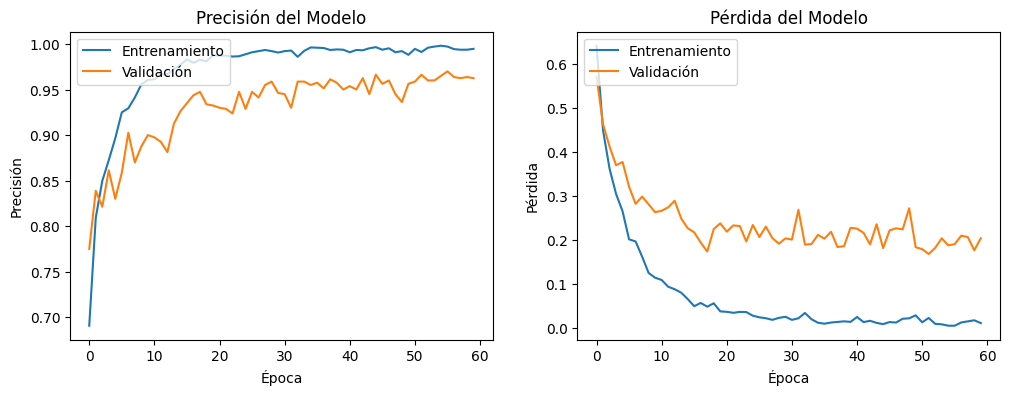

In [ ]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

## Tercer modelo

In [9]:
# Construyo el modelo simple
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.65),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.65),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.65),
    # Conv2D(16, (3, 3), activation='relu'),
    # MaxPooling2D((2, 2)),
    # Dropout(0.65),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       460,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,169 (1.81 MB)

 Trainable params: 475,169 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Entreno el modelo
history = model.fit(X_train_mri, y_train_mri, epochs=130, batch_size=64, validation_split=0.2)

In [11]:
# Evaluo el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_mri, y_test_mri)

print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9612 - loss: 0.1621
Pérdida en el conjunto de prueba: 0.1624
Precisión en el conjunto de prueba: 0.9680


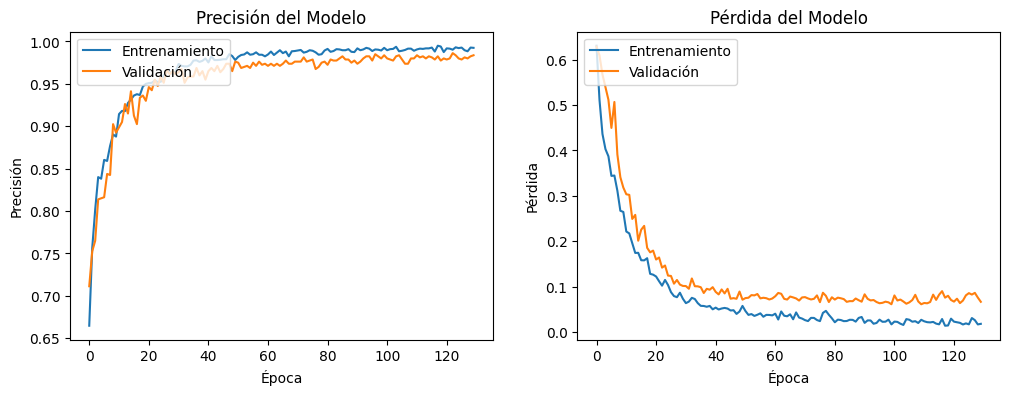

In [12]:
# Grafico de precisión en entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Grafico de loss en entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()